# Q9. 
Select a camera that you would like to use for the assignments. Note that you might be using this camera for future assignments also. This could be your laptop camera, mobile phone camera or any other digital camera that you have access to.

## Ans
I have selected my phone camera for this purpose. It’s usage in the context of this assignment is explained in detail in the below solution. 

# Q10. 
Repeat the 3 calibration methods using your own camera and your own calibration object for which you measure and determine the world co-ordinates. Use a printed checkerboard pattern for Zhang’s method. Describe and comment on the results of each method.

## Ans
The calibration object chosen for the experiments was my laptop, whose image was captured by my phone's camera. The relevant experiments performed for previous tasks are performed for this camera - object pair below. 10 different images of checkerboard pattern were used for Zhang method.

10 points (the corners of the laptop) are used for the calibration process.

In [1]:
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt

In [2]:
def estimate_matrix(world_points, image_points):
    A = []
    for i in range(len(world_points)):
        X, Y, Z = tuple(world_points[i])
        u, v = tuple(image_points[i])
        eqn_1 = [X, Y, Z, 1] + [0] * 4 + [-u * X, -u * Y, -u * Z, -u]
        eqn_2 = [0] * 4 + [X, Y, Z, 1] + [-v * X, -v * Y, -v * Z, -v]
        A.append(eqn_1)
        A.append(eqn_2)
    U, S, V = np.linalg.svd(A)
    if V[-1, -1] == 0:
        return np.zeros((3, 4)), False
    return (V[-1, :] / V[-1, -1]).reshape(3, 4), True

In [3]:
def decompose_P(P):
    M = P[:, :3]
    R, K = np.linalg.qr(np.linalg.inv(M))
    K = np.linalg.inv(K)
    K /= K[-1, -1]
    R = np.linalg.inv(R)
    t = -1 * (np.linalg.inv(M) @ P[:, 3])
    return K, R, t

In [4]:
def get_total_error(world_points, image_points, P):
    n = len(image_points)
    total_error = 0
    for i in range(n):
        pred_point = P @ np.asarray(world_points[i] + [1])
        pred_point = pred_point / pred_point[-1]
        total_error += np.sum((pred_point[:2] - np.asarray(image_points[i])) ** 2)
    return total_error

In [5]:
def direct_linear_transform(world_points, image_points):
    if len(world_points) != len(image_points) or len(world_points[0]) != 3 or len(image_points[0]) != 2:
        print("Invalid parameters for world and image co-ordinates")
        return
    if len(world_points) < 6:
        print("Atleast 6 points are necessary for calibration")
        return
    P, is_valid = estimate_matrix(world_points, image_points)
    if not is_valid:
        print("Invalid camera matrix")
        return
    K, R, t = decompose_P(P)
    return P, K, R, t

In [6]:
def RANSAC(world_points, image_points, N_iter=10000, threshold=50, sample_size=6):
    if len(world_points) != len(image_points) or len(world_points[0]) != 3 or len(image_points[0]) != 2:
        print("Invalid parameters for world and image co-ordinates")
        return
    if len(world_points) < 6:
        print("Atleast 6 points are necessary for calibration")
        return
    P = np.zeros((3, 4))
    min_outlier_count = 10 ** 300
    for _ in range(N_iter):
        chosen_indices = np.random.choice(list(range(len(world_points))), size=sample_size, replace=False)
        chosen_world_points = [world_points[i] for i in chosen_indices]
        chosen_image_points = [image_points[i] for i in chosen_indices]
        possible_P, is_valid = estimate_matrix(chosen_world_points, chosen_image_points)
        if not is_valid:
            continue
        outlier_count = 0
        for i in range(len(world_points)):
            if i in chosen_indices:
                continue
            pred_point = possible_P @ np.asarray(world_points[i] + [1])
            if pred_point[-1] == 0:
                outlier_count += 1
                continue
            pred_point = pred_point / pred_point[-1]
            dist = np.sum((pred_point[:2] - np.asarray(image_points[i])) ** 2) ** 0.5
            if dist > threshold:
                outlier_count += 1
        if outlier_count < min_outlier_count:
            min_outlier_count = outlier_count
            P = possible_P
    K, R, t = decompose_P(P)
    return P, K, R, t

In [7]:
def get_image_points():
    line_1 = [[16, 775], [1263, 790]]
    line_2 = [[297, 493], [976, 507]]
    line_3 = [[323, 444], [953, 454]]
    line_4 = [[308, 68], [984, 81]]
    line_5 = [[1013, 46], [277, 39]]
    return line_1 + line_2 + line_3 + line_4 + line_5

def get_world_points():
    line_1 = [[370, 0, 255], [0, 0, 255]]
    line_2 = [[370, 0, 0], [0, 0, 0]]
    line_3 = [[358, 27, 0], [17, 27, 0]]
    line_4 = [[358, 226, 0], [17, 226, 0]]
    line_5 = [[0, 245, 0], [370, 245, 0]]
    return line_1 + line_2 + line_3 + line_4 + line_5

image = cv.imread('../images/laptop.jpg')
image_points = get_image_points()
world_points = get_world_points()

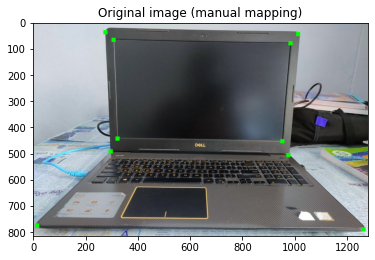

In [8]:
original_image = image.copy()
X_OFFSET = 8
Y_OFFSET = 8
for image_point in image_points:
    original_image[image_point[1] - Y_OFFSET:image_point[1] + Y_OFFSET,  
            image_point[0] - X_OFFSET:image_point[0] + X_OFFSET] = [0, 255, 0]
plt.imshow(original_image)
plt.title("Original image (manual mapping)")
plt.show()

In [9]:
def display_outputs(approach, image_points, P, K, R, t, color, given_image):
    global world_points, X_OFFSET, Y_OFFSET
    print(f"*** On using {approach} approach for camera calibration ***\n\n")
    print(f"Camera matrix (P): \n\n{P}\n")    
    print(f"Internal camera calibration matrix (K): \n\n{K}\n")
    print(f"Camera rotation matrix (R): \n\n{R}\n")    
    print(f"Camera projection centre (translation vector t): \n\n{t}\n")
    print(f"Total Projection error (sum): \n\n{get_total_error(world_points, image_points, P)}\n")
    if "distort" not in approach:
        for i in range(len(world_points)):
            pred_point = P @ np.asarray(world_points[i] + [1])
            pred_point = pred_point / pred_point[-1]
            pred_point = pred_point.astype(int)
            given_image[pred_point[1] - Y_OFFSET:pred_point[1] + Y_OFFSET,  
                    pred_point[0] - X_OFFSET:pred_point[0] + X_OFFSET] = color
        plt.imshow(given_image)

*** On using DLT approach for camera calibration ***


Camera matrix (P): 

[[-1.83642630e+00 -1.67843774e-01 -1.13880219e+00  9.78576574e+02]
 [-2.97245129e-02 -1.88331258e+00 -2.81958989e-01  5.03193083e+02]
 [-4.04128384e-06 -3.17575153e-04 -1.78475762e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.01178972e+03  2.99321758e+00  6.36964047e+02]
 [-0.00000000e+00 -9.95708016e+02  3.35168820e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-9.99873990e-01  1.58647865e-02 -5.58892353e-04]
 [-1.57173150e-02 -9.84407658e-01  1.75198540e-01]
 [ 2.22930952e-03  1.75185248e-01  9.84532965e-01]]

Camera projection centre (translation vector t): 

[189.19398182 185.31493626 526.8973115 ]

Total Projection error (sum): 

153.66135435657836



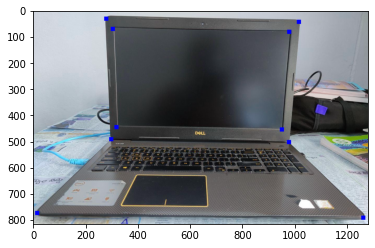

In [10]:
dlt_image = image.copy()
P, K, R, t = direct_linear_transform(world_points, image_points)
display_outputs("DLT", image_points, P, K, R, t, [0, 0, 255], dlt_image)

## Observations
It can clearly be observed that the error obtained in this case (on using DLT) is significantly low. This can be primarily attributed to lesser number of points considered for this object (10) in comparison to the high number of points utilized in the previous tasks (36). This has relaxed the constraints and number of terms in the sum to a big extent, and thus significantly reduced the magnitude of the error. This can also be observed in the near perfect alignment of the predicted points and the actual points.

*** On using RANSAC approach for camera calibration ***


Camera matrix (P): 

[[-1.82901420e+00 -1.81905009e-01 -1.13932185e+00  9.76097403e+02]
 [-1.31288104e-02 -1.89678226e+00 -2.90363173e-01  5.04413791e+02]
 [ 2.21883282e-05 -3.61589875e-04 -1.79284044e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.00777028e+03  1.38447718e+01  6.18085304e+02]
 [-0.00000000e+00 -9.85230459e+02  3.60524548e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-0.99985768  0.00909575 -0.01420879]
 [-0.01172449 -0.98022239  0.19755151]
 [-0.0121309   0.19768999  0.98018953]]

Camera projection centre (translation vector t): 

[189.59780153 184.57320762 522.89486161]

Total Projection error (sum): 

316.74000555389335



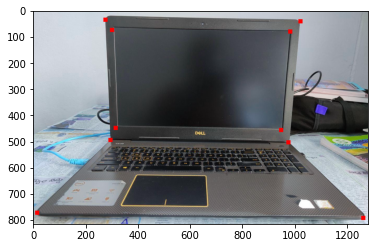

In [11]:
RANSAC_image = image.copy()
P, K, R, t = RANSAC(world_points, image_points)
display_outputs("RANSAC", image_points, P, K, R, t, [255, 0, 0], RANSAC_image)

## Observations
It can be observed that the error value, though low (due to lesser number of points being considered) is higher than in the above case of direct linear transform. This can be attributed to the randomization and lesser number of points which are used for validating P matrix. This happens because there are 10 correspondences in total and 6 are being used for estimating 6, leaving aside only 4 points for the sake of validation (outlier count).

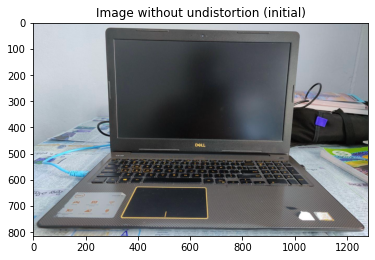



Distortion co-efficients are: 
Radial distortion: k1 = 0.14180692375497622, k2 = -0.0026041575069563755, k3 = -0.6815353319755556
Tangential distortion: p1 = 0.0511643232198909, p2 = 0.0037434106647562778


New camera matrix: 
[[964.07769775   0.         630.06415775]
 [  0.         947.5557251  448.79074386]
 [  0.           0.           1.        ]]




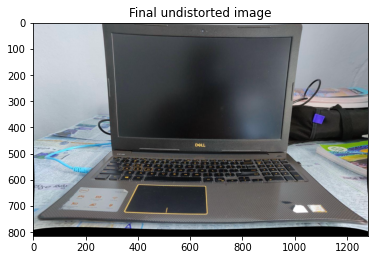

In [12]:
def get_distortion_params(K, image):
    global world_points, image_points
    plt.title("Image without undistortion (initial)")
    plt.imshow(image)
    plt.show()
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    wp = np.asarray([np.asarray(world_points[i]) for i in range(len(world_points))])
    ip = np.asarray([np.asarray(image_points[i]) for i in range(len(image_points))])
    obj_pts = [wp.astype('float32')]
    img_pts = [ip.astype('float32')]
    K = K @ [[-1,0,0],[0,-1,0],[0,0,1]] 
    K[0,1] = 0
    ret_val, new_K, distortion_coeffs, rvecs, tvecs = cv.calibrateCamera(obj_pts, img_pts, gray_image.shape[::-1], 
                                                                         K, None, None, flags = (cv.CALIB_USE_INTRINSIC_GUESS))
    print("\n\nDistortion co-efficients are: ")
    k1, k2, k3 = distortion_coeffs[0][0], distortion_coeffs[0][1], distortion_coeffs[0][4]
    p1, p2 = distortion_coeffs[0][2], distortion_coeffs[0][3]
    print(f"Radial distortion: k1 = {k1}, k2 = {k2}, k3 = {k3}")
    print(f"Tangential distortion: p1 = {p1}, p2 = {p2}\n\n")
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(new_K, distortion_coeffs, image.shape[:2], 0, image.shape[:2])
    undistorted_image = cv.undistort(image, new_K, distortion_coeffs, new_camera_matrix)
    plt.imshow(undistorted_image)
    plt.title("Final undistorted image")
    print(f"New camera matrix: \n{new_camera_matrix}\n\n")
    return k1, k2, k3, p1, p2, rvecs, tvecs, new_camera_matrix, undistorted_image

k1, k2, k3, p1, p2, rvec, tvec, camera_matrix, undistorted_image = get_distortion_params(K, image.copy())
wp = [np.asarray(np.asarray([world_points[i]])) for i in range(len(world_points))]
new_image_points, jacobian = cv.projectPoints(np.asarray(wp).astype('float32'), rvec[0], tvec[0], camera_matrix, np.asarray([k1, k2, p1, p2, k3]))

In [13]:
# Repeating above experiments with radial distortion rectification
undistort_dlt_image = undistorted_image.copy()
P, K, R, t = direct_linear_transform(world_points, new_image_points.reshape(10, 2))
display_outputs("DLT (after correcting for radial distortion)", new_image_points.reshape(10, 2), P, K, R, t, [0, 0, 255], undistort_dlt_image)

*** On using DLT (after correcting for radial distortion) approach for camera calibration ***


Camera matrix (P): 

[[-1.88147766e+00 -1.71498143e-01 -1.15683549e+00  9.96822811e+02]
 [-3.02384215e-02 -1.88146366e+00 -2.81499380e-01  5.02840033e+02]
 [-4.30756242e-06 -3.16606007e-04 -1.78468026e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.03665210e+03  1.76902631e+00  6.47416216e+02]
 [-0.00000000e+00 -9.95060212e+02  3.34272501e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-9.99869691e-01  1.61368981e-02 -4.49401366e-04]
 [-1.59672664e-02 -9.84494036e-01  1.74689838e-01]
 [ 2.37651914e-03  1.74674250e-01  9.84623410e-01]]

Camera projection centre (translation vector t): 

[188.89368944 185.37859077 526.98198862]

Total Projection error (sum): 

49.9019326039908



In [14]:
undistort_RANSAC_image = undistorted_image.copy()
P, K, R, t = RANSAC(world_points, new_image_points.reshape(10, 2))
display_outputs("RANSAC (after correcting for radial distortion)", new_image_points.reshape(10, 2), P, K, R, t, [255, 0, 0], undistort_RANSAC_image)

*** On using RANSAC (after correcting for radial distortion) approach for camera calibration ***


Camera matrix (P): 

[[-1.88355036e+00 -1.83146148e-01 -1.14945605e+00  9.95618144e+02]
 [-4.28186140e-02 -1.86836241e+00 -2.79371656e-01  5.01865995e+02]
 [-2.63913932e-05 -3.28353736e-04 -1.78264887e-03  1.00000000e+00]]

Internal camera calibration matrix (K): 

[[-1.02966570e+03 -4.02155201e+00  6.56936413e+02]
 [-0.00000000e+00 -9.85843709e+02  3.38562690e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Camera rotation matrix (R): 

[[-0.99971426  0.02128433  0.01087991]
 [-0.01895933 -0.98322922  0.18138589]
 [ 0.01455812  0.18112778  0.98335181]]

Camera projection centre (translation vector t): 

[190.79674286 185.90325546 523.89598048]

Total Projection error (sum): 

85.55446163865932



## Observations
It can be seen that there has been an improvement in the calibration performances of DLT and RANSAC, on performing on an undistorted image. This can be said because error values for both cases have reduced significantly on considering the camera parameters after calibration with respect to distortion co-efficients.

WIREFRAMES


DLT: 




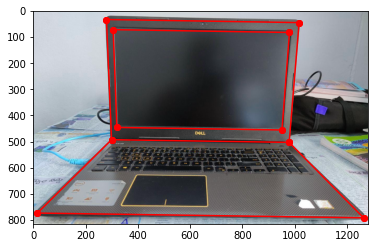


RANSAC: 




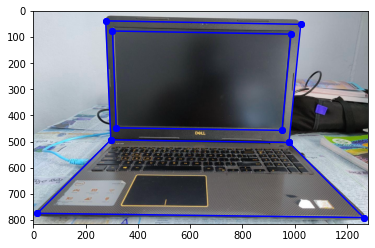

In [15]:
def draw_wireframe(P, image, color):
    plt.imshow(image)
    global world_points
    image_points = []
    for i in range(len(world_points)):
        pred_point = P @ np.asarray(world_points[i] + [1])
        pred_point = pred_point / pred_point[-1]
        image_points.append(pred_point)
    for i in range(0, 10, 2):
        plt.plot([image_points[i][0], image_points[i+1][0]], [image_points[i][1], image_points[i+1][1]], color)
    col_edges = [(0, 2), (1, 3), (2, 9), (3, 8), (4, 6), (5, 7)]
    image_points = np.asarray(image_points)
    for _edge in col_edges:
        i1, i2 = _edge
        plt.plot([image_points[i1][0], image_points[i2][0]], [image_points[i1][1], image_points[i2][1]], color)
    plt.show()

print("WIREFRAMES\n\n")
print("DLT: \n\n")
draw_wireframe(direct_linear_transform(world_points, image_points)[0], image.copy(), 'ro-')
print("\nRANSAC: \n\n")
draw_wireframe(RANSAC(world_points, image_points)[0], image.copy(), 'bo-')

In [36]:
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

def zhang():
    image_names = [f"checkerboard-0{i}.jpg" for i in range(1, 10)] + [f"checkerboard-{i}.jpg" for i in range(10, 11)]
    edge_length, inner_row_count, inner_col_count, board_world_coords = 24, 6, 10, []
    for y in range(0, edge_length * inner_row_count, edge_length):
        for x in range(0, edge_length * inner_col_count, edge_length):
            board_world_coords.append(np.asarray([x, y, 0]))
    board_world_coords = np.asarray(board_world_coords)
    
    world_coords, image_coords = [], []
    for _n in image_names:
        board_image = cv.imread('../images/' + _n)
        gray_image = cv.cvtColor(board_image, cv.COLOR_BGR2GRAY)
        ret_val, corners = cv.findChessboardCorners(gray_image, (inner_col_count, inner_row_count))
        world_coords.append(board_world_coords)
        image_coords.append(corners)
    world_coords = np.asarray(world_coords).astype(np.float32)
    image_coords = np.asarray(image_coords).astype(np.float32)
    
    ret_val, K, distortion_coeffs, rvecs, tvecs = cv.calibrateCamera(world_coords, image_coords, gray_image.shape[::-1], None, None)
    print(f"Internal camera calibration matrix (K): \n\n{K}\n")
    print("\nDistortion co-efficients are: ")
    k1, k2, k3 = distortion_coeffs[0][0], distortion_coeffs[0][1], distortion_coeffs[0][4]
    p1, p2 = distortion_coeffs[0][2], distortion_coeffs[0][3]
    print(f"Radial distortion: k1 = {k1}, k2 = {k2}, k3 = {k3}")
    print(f"Tangential distortion: p1 = {p1}, p2 = {p2}\n\n")
    print(f"\nRotation vectors: \n\n{rvecs}\n")
    print(f"\nTranslation vectors: \n\n{tvecs}\n")
    
    R = eulerAnglesToRotationMatrix(rvecs[0])
    t = tvecs[0][:, 0]
    P = K @ np.column_stack((R, t))
    print(f"\nTotal Projection error (sum): \n\n{get_total_error(board_world_coords.tolist(), image_coords[0].reshape(60, 2), P)}\n")
    return k1, k2, k3, p1, p2, P, K, board_world_coords

k1_b, k2_b, k3_b, p1_b, p2_b, P_board, K_board, board_world_coords = zhang()

Internal camera calibration matrix (K): 

[[1.41673993e+03 0.00000000e+00 6.95756549e+02]
 [0.00000000e+00 1.41649252e+03 4.79315644e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


Distortion co-efficients are: 
Radial distortion: k1 = -0.04668449583689275, k2 = 0.6039117153471165, k3 = -1.8997871836395828
Tangential distortion: p1 = 0.0030134397640145844, p2 = 0.0025500253322670308



Rotation vectors: 

(array([[ 0.15135413],
       [-0.00639259],
       [ 0.01151029]]), array([[ 0.22000992],
       [-0.06351365],
       [ 0.00520393]]), array([[ 0.1115811 ],
       [-0.32207258],
       [ 0.24689778]]), array([[0.14617917],
       [0.25904811],
       [0.04644949]]), array([[0.17119187],
       [0.0516114 ],
       [0.03870679]]), array([[ 0.09318115],
       [-0.21046607],
       [-0.03119612]]), array([[ 0.05496494],
       [-0.02364642],
       [-0.0556194 ]]), array([[ 0.22349581],
       [-0.17918152],
       [-0.02745953]]), array([[-0.02702715],
       [-0.05142277],


## Observations
It can be seen that the camera calibration matrix ‘K’ and the distortion parameters obtained on using Zhang’s method are fairly similar to the parameters obtained on using DLT. 

Here, Zhang method seemed to perform more effectively than DLT and RANSAC (on image with distortion), which implies the data captured by checkerboards in their various images assisted in more accurate calibration, in comparison with the limited number of points (laptop corners) used for DLT and RANSAC. 

The undistorted images also seem to pan out similar to the case of DLT.

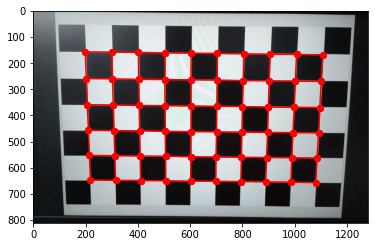

WIREFRAME OF BOARD (ZHANG'S METHOD) 


New camera matrix: 
[[1.41679077e+03 0.00000000e+00 6.95781533e+02]
 [0.00000000e+00 1.41386047e+03 4.79803433e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]




In [51]:
def zhang_wireframe_and_undistort(k1, k2, k3, p1, p2, P, K, board_world_coords, image, color):
    img_points = []
    plt.imshow(image)
    for i in range(len(board_world_coords)):
        pred_point = P @ np.asarray(board_world_coords[i].tolist() + [1])
        pred_point = pred_point / pred_point[-1]
        pred_point = pred_point.astype(int)
        img_points.append(pred_point)
    img_points = np.asarray(img_points)
    for i in range(len(board_world_coords) - 1):
        if i % 10 == 9:
            continue
        plt.plot([img_points[i][0], img_points[i+1][0]], [img_points[i][1], img_points[i+1][1]], color)
    for i in range(10):
        for j in range(i, 50, 10):
            plt.plot([img_points[j][0], img_points[j+10][0]], [img_points[j][1], img_points[j+10][1]], color)
    plt.show()
    print("WIREFRAME OF BOARD (ZHANG'S METHOD) \n\n")
    new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(K, np.asarray([[k1, k2, p1, p2, k3]]), image.shape[:2], 0, image.shape[:2])
    undistorted_image = cv.undistort(image, K, np.asarray([[k1, k2, p1, p2, k3]]), new_camera_matrix)
    print(f"New camera matrix: \n{new_camera_matrix}\n\n")
    return undistorted_image
    
img = cv.imread('../images/checkerboard-01.jpg')  
undistorted_image = zhang_wireframe_and_undistort(k1_b, k2_b, k3_b, p1_b, p2_b, 
                                                  P_board, K_board, board_world_coords, img, 'ro-')

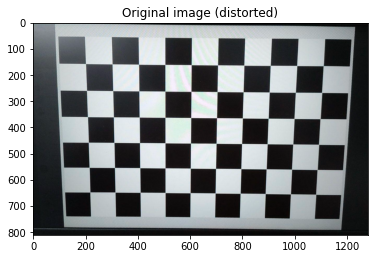

In [52]:
plt.imshow(img)
plt.title("Original image (distorted)")
plt.show()

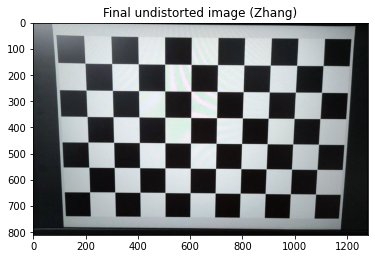

In [53]:
plt.imshow(undistorted_image)
plt.title("Final undistorted image (Zhang)")
plt.show()

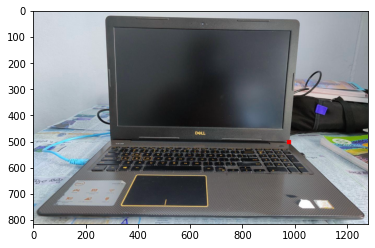

In [20]:
def plot_origin(P, color, given_image):
    world_origin = P @ np.asarray([0, 0, 0, 1])
    world_origin /= world_origin[-1]
    world_origin = np.asarray(world_origin).astype(int)
    given_image[world_origin[1] - Y_OFFSET:world_origin[1] + Y_OFFSET,  
                world_origin[0] - X_OFFSET:world_origin[0] + X_OFFSET] = color
    plt.imshow(given_image)
    plt.show()

plot_origin(direct_linear_transform(world_points, image_points)[0], [255, 0, 0], image.copy())

# Challenges faced across experiments

* Significant errors in estimation were observed on using the calibration methods, which suggests skewness in the camera matrix, which was not very accurate (although fairly good).
* It was difficult to capture distinctive types (angles) of images of checkerboard with camera of the phone, for Zhang's method of estimation, and hence this reflected in some error in estimation (due to not-so-great quality images captured).
* Sometimes wireframes didn't come out well (were not joining relevant points as well as expected), especially on undistorted images.
* Tuning the hyperparameters for RANSAC approach was a challenging task.